In [9]:
import torch
import torch.nn as nn
from torch.distributions import Categorical, OneHotCategorical
from matplotlib import pyplot as plt
from unet import UNet
from tqdm import tqdm
import numpy as np

from unet import UNet
import glob
import os

from torch.utils.data import TensorDataset, DataLoader, Dataset
from PIL import Image

device='cuda' if torch.cuda.is_available() else 'cpu'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
ref_dataset = None

In [10]:
data_dir='data/TinyCelebA_10k2'
K_colors = 32

In [11]:
def one_hotize(im, k=K_colors):
    ''' input: [0,1] HxW image
        output: {0,1} HxWxK image'''
    im = torch.floor(im/256.0*k).long()
    return torch.nn.functional.one_hot(im, k).permute((2,0,1))

def de_one_hotize(oh, dim=1):
    ''' input: {0,1} HxWxK image
        output: [0,1] HxW image'''
    return oh.argmax(dim)/oh.shape[dim]

def contains(source, elements):
    out = torch.zeros_like(source, dtype=torch.bool)
    for e in elements:
        out = torch.logical_or(out, source==e)
    return out

In [12]:
class ImageDataset(Dataset):
    def __init__(self, root, k=None):
        end = "/*.jpg"
        self.files = sorted(glob.glob(root + end))
        if not k is None:
            self.files = self.files[:k]

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)]).convert('L')
        img = torch.tensor(np.array(img))
        return one_hotize(img)

    def __len__(self):
        return len(self.files)
dataset = ImageDataset(data_dir)
H,W = dataset[1].shape[1:]

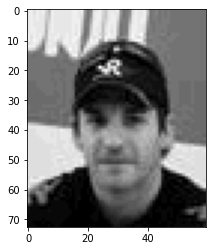

In [13]:
plt.imshow(de_one_hotize(dataset[np.random.randint(len(dataset))],0), cmap='gray')

In [14]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=True) 

In [15]:
def cust_show(out,**kwargs):
    plt.imshow(out.cpu().detach().numpy(), **kwargs)
    plt.show()

In [16]:
class AODM(nn.Module):
    def __init__(self, h=H, w=W, k=K_colors, lr=1e-4):
        super().__init__()
        self.h, self.w, self.k = h, w, k
        self.d = self.h * self.w
        self.unet = UNet(self.k, self.k)
        self.lr = lr
        self.loss_hist = torch.zeros(self.d).to(device)
        self.loss_hist_n = torch.zeros(self.d).to(device)

    def forward(self, x):
        x_ = self.unet(x)
        return torch.log_softmax(x_, dim=1)

    def sample_t(self, N):
        return torch.randint(1, self.d + 1, (N, 1, 1), device=device)

    def sample_sigma(self, N):
        return torch.stack([torch.randperm(self.d, device=device).reshape(self.h, self.w) + 1 for _ in range(N)])

    def sigma_with_mask(self, mask):
        # sigma = [1.. mask_pixels || randperm (remaining pixels) ]
        sigma = torch.zeros((1, self.h, self.w), dtype=torch.long, device=device)
        sigma[mask] = torch.arange(mask.sum()) + 1
        sigma[~mask] = torch.randperm(self.d - mask.sum(), device=device) + mask.sum()
        return sigma

    def training_step(self, x):
        N, K, H, W = x.shape
        t = self.sample_t(N)
        sigma = self.sample_sigma(N)
        mask = sigma < t
        mask = mask.unsqueeze(1).float()
        x_ = self(x * mask)
        C = Categorical(logits=x_.permute(0, 2, 3, 1))
        l = (1. - mask) * C.log_prob(torch.argmax(x, dim=1)).unsqueeze(1)
        n = 1. / (self.d - t + 1.)
        l = n.flatten() * l.sum(dim=(1, 2, 3))
        ### loss:
        with torch.no_grad():
            self.loss_hist[t.flatten().long()-1] += - l
            self.loss_hist_n[t.flatten().long()-1] += 1
        return {'loss': -l.mean(), 'input': x.detach(), 'generated': x_.detach()}

    def training_step_end(self, o):
        self.log('loss', o['loss'])

    def validation_step(self, *args, **kwargs):
        sample = self.sample_one()
        self.sample_quality(sample)
        return {'sample': sample.cpu()}

    def validation_epoch_end(self, outputs):
        self.log('sample_quality', self.sample_quality.compute())

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.lr)
        return [opt]

    def sample_one(self):
        x = torch.zeros(1, self.k, self.h, self.w, device=device)
        sigma = self.sample_sigma(1)
        for t in range(1, self.d + 1):
            x = self.sample_step(x, t, sigma)
        return x

    def sample_one_seeded(self, x_seed, mask):

        # add masked pixels to seed
        x = torch.zeros(1, self.k, self.h, self.w, device=device)
        x[mask] = x_seed[mask]
        sigma = self.sigma_with_mask(mask)

        for t in range(mask.sum(), self.d + 1):
            x = self.sample_step(x, t, sigma)
        return x

    def sample_step(self, x, t, sigma):
        """
        Performs one step of the noise reversal transition function in order sigma at time t
        x: the current state
        t: the current timestep
        sigma: the order
        """
        past, current = sigma < t, sigma == t
        past, current = past.unsqueeze(1).float(), current.unsqueeze(1).float()
        logprobs = self((x * past))
        x_ = OneHotCategorical(logits=logprobs.permute(0, 2, 3, 1)).sample().permute(0, 3, 1, 2)
        x = x * (1 - current) + x_ * current
        return x
    def sample_step_cust(self, x, t, sigma):
        past = sigma < t[0]
        current = contains(sigma, t)
        past, current = past.unsqueeze(1).float(), current.unsqueeze(1).float()
        logprobs = self((x * past))
        x_ = OneHotCategorical(logits=logprobs.permute(0, 2, 3, 1)).sample().permute(0, 3, 1, 2)
        x = x * (1 - current) + x_ * current
        return x
    
    def sample_one_cust(self, k=3):
        x = torch.zeros(1, self.k, self.h, self.w, device=device)
        sigma = self.sample_sigma(1)
        for t in range(1, self.d + 1, k):
            x = self.sample_step_cust(x, torch.arange(t, t+k), sigma)
        return x
    
    def sample_one_exp(self):
        x = torch.zeros(1, self.k, self.h, self.w, device=device)
        k = 1
        t = 1
        sigma = self.sample_sigma(1)
        while t+k<self.d:
            x = self.sample_step_cust(x, torch.arange(t, t+k), sigma)
            t += k
            k += 1
        x = self.sample_step_cust(x, torch.arange(t, self.d), sigma)
        return x

    def sample_one_path(self, path, n=1, save_list=False):
        x = torch.zeros(n, self.k, self.h, self.w, device=device)
        t = 1
        sigma = self.sample_sigma(1)
        L=[]
        for i in tqdm(range(1, len(path))):
            if path[i-1]< path[i]:
                x = self.sample_step_cust(x, torch.arange(path[i-1], path[i]), sigma)
                if save_list:
                    L.append(x.cpu().detach().numpy())
        if save_list:
            return x, L
        return x





In [10]:
#model = AODM()
model = torch.load('face_large_working6.pt').to(device)
L=[]

# Train Model

In [11]:
model.lr = 1e-4
opt = model.configure_optimizers()[0]

In [12]:
if False:
    for i in tqdm(range(100)):
       # model.eval()
        #out = model.sample_one()
        #plt.imsave('figs/epoch_{}.png'.format(i), out[0,1].cpu().detach().numpy())

        model.train()
        l=0
        print('saving model')
        torch.save(model, 'face_large4.pt')
        print('model saved')
        for idx, batch in enumerate(dataloader):
            x = batch.to(device)
            opt.zero_grad()
            out = model.training_step(x)
            loss = out['loss']
            l+=loss.item()
            loss.backward()
            opt.step()
        L.append(l)
        plt.plot(L)
        plt.show()
   

# Evaluate Model

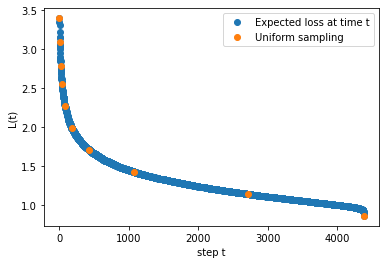

In [13]:
loss_array = np.load('saved_loss.npy')

def divide_array(arr, n):
    steps = (arr[0]-arr[-1])/(n-1)
    L = [0]
    
    for i in range(1, n-1):
        mask = (arr < arr[0]-i*steps)
        ind = mask.argmax()
        if ind <= L[-1]:
            ind = L[-1]+1
            if ind >= len(arr):
                ind = len(arr)-1
        L.append(ind)
    L.append(len(arr)-1)
    return L

x = divide_array(loss_array, 10)
y = loss_array[x]
plt.plot(loss_array, 'o', label='Expected loss at time t')
plt.plot(x,y, 'o', label='Uniform sampling')
plt.xlabel('step t')
plt.ylabel('L(t)')
plt.legend()
#plt.savefig('figs/uniform_samplingb.png')
plt.show()


In [16]:
model.eval()
nstep=800
x = divide_array(loss_array, nstep)
out = model.sample_one_path(x, 10)

100%|█████████████████████████████████████████| 799/799 [00:15<00:00, 52.00it/s]


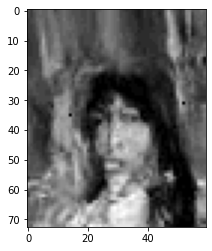

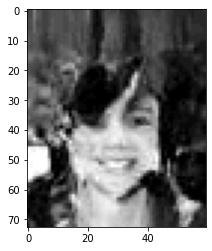

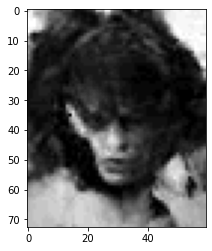

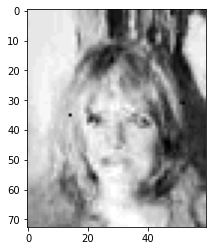

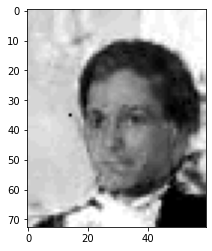

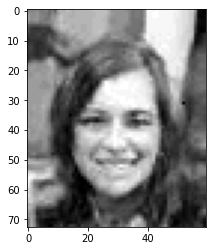

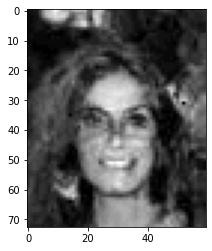

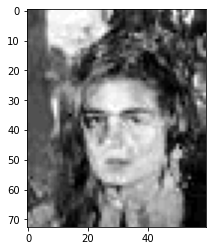

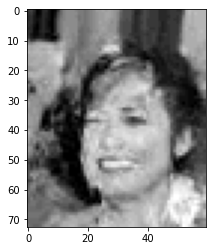

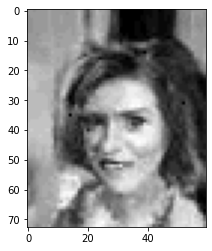

In [17]:
for i in range(out.shape[0]):
    gen_im = de_one_hotize(out)[i].cpu().detach().numpy()
    plt.imshow(gen_im, cmap='gray')
    plt.show()

# Generate Dataset

100%|█████████████████████████████████████████████| 9/9 [00:02<00:00,  3.68it/s]


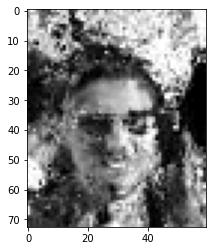

100%|███████████████████████████████████████████| 99/99 [00:22<00:00,  4.31it/s]


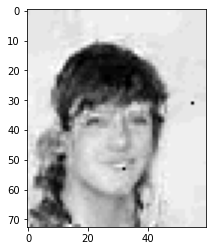

100%|█████████████████████████████████████████| 199/199 [00:46<00:00,  4.26it/s]


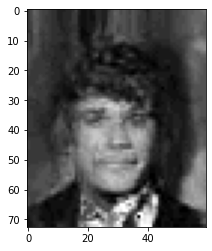

100%|█████████████████████████████████████████| 399/399 [01:34<00:00,  4.20it/s]


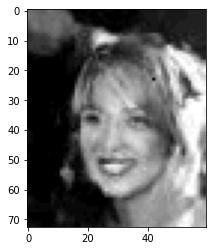

100%|█████████████████████████████████████████| 799/799 [03:14<00:00,  4.10it/s]


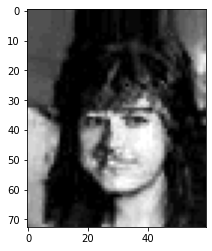

100%|███████████████████████████████████████| 1599/1599 [06:30<00:00,  4.10it/s]


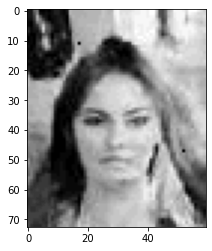

In [22]:
model.eval()
nstep=1600


for nstep in [10,100,200,400,800,1600]:
    x = divide_array(loss_array, nstep)
    out = model.sample_one_path(x, 200)
    for i in range(out.shape[0]):
        gen_im = de_one_hotize(out)[i].cpu().detach().numpy()
        plt.imsave('figs/out_face_large_{}/{}.jpeg'.format(nstep, i), gen_im, cmap='gray')
        if i==0:
            plt.imshow(gen_im, cmap='gray')
            plt.show()

# Compute FID score

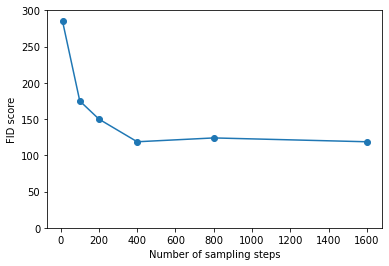

In [25]:
plt.plot([10, 100, 200, 400, 800, 1600], [285, 175, 150, 118.7, 124, 118.7], 'o-')
plt.ylim([0,300])
plt.xlabel('Number of sampling steps')
plt.ylabel('FID score')
#plt.savefig('figs/uniform_sampling2b.png')
plt.show()


# Progressive generation

100%|████████████████████████████████████████| 799/799 [00:05<00:00, 133.55it/s]


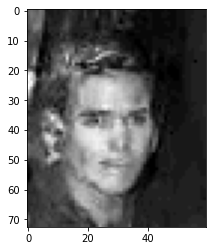

In [69]:
model.eval()
nstep=800
x = divide_array(loss_array, nstep)
out = model.sample_one_path(x, 1, True)
arr = out[1]
plt.imshow(de_one_hotize(arr[-1][0], 0), cmap='gray')
plt.show()

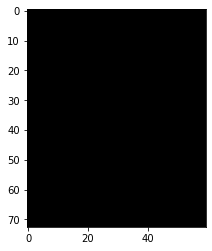

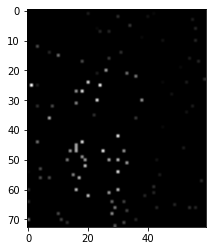

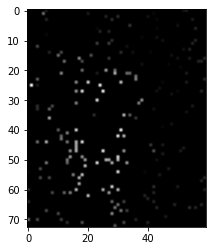

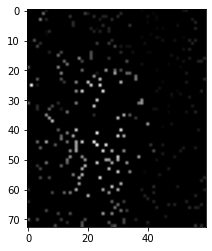

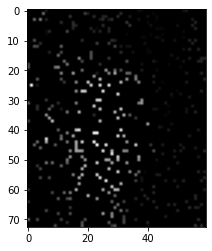

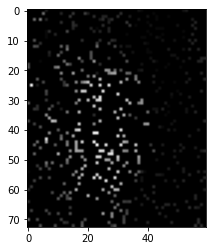

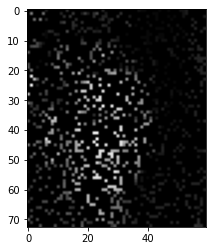

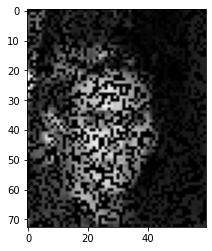

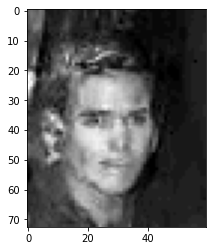

In [73]:
for i in range(0,800, 100):
    plt.imsave('figs/progressive/{}.jpeg'.format(i), de_one_hotize(arr[i][0], 0), cmap='gray')
    plt.imshow(de_one_hotize(arr[i][0], 0), cmap='gray')
    plt.show()
plt.imsave('figs/progressive/{}.jpeg'.format(i+100), de_one_hotize(arr[-1][0], 0), cmap='gray')
plt.imshow(de_one_hotize(arr[-1][0], 0), cmap='gray')
plt.show()

# Test overfit

In [61]:
if ref_dataset is None:
    L=[]
    for i in tqdm(range(len(dataset))):
        L.append(de_one_hotize(dataset[i][None,...]))
    ref_dataset = torch.cat(L)

In [151]:
def closest(tens):
    mask = torch.zeros_like(tens)
    mask[30:40, 20:40]=1
    comp = ((ref_dataset-tens[None,:])**2)*mask
    return ref_dataset[comp.sum((1,2)).argmin()]

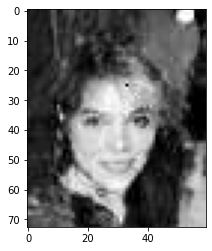

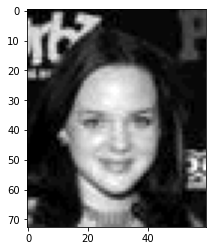

In [169]:
i=np.random.randint(199)
im = torch.tensor(plt.imread('figs/out_face_large_800/{}.jpeg'.format(i)), dtype=torch.float32).mean((2))/255.0
plt.imshow(im, cmap='gray')
plt.show()
clos = closest(im)
plt.imshow(clos, cmap='gray')
plt.show()

In [170]:
plt.imsave('figs/overfit2/{}source.jpeg'.format(i), im, cmap='gray')
plt.imsave('figs/overfit2/{}target.jpeg'.format(i), clos, cmap='gray')